<a href="https://colab.research.google.com/github/Prasad-Krishna-Murthy/Reinforcement-Learning---IIIT-Dharwad/blob/main/RL_Prog_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prasad K

24PHDDI07

prasad.24phddi07@iiitdwd.ac.in

#I. PROGRAMMING ON Q LEARNING

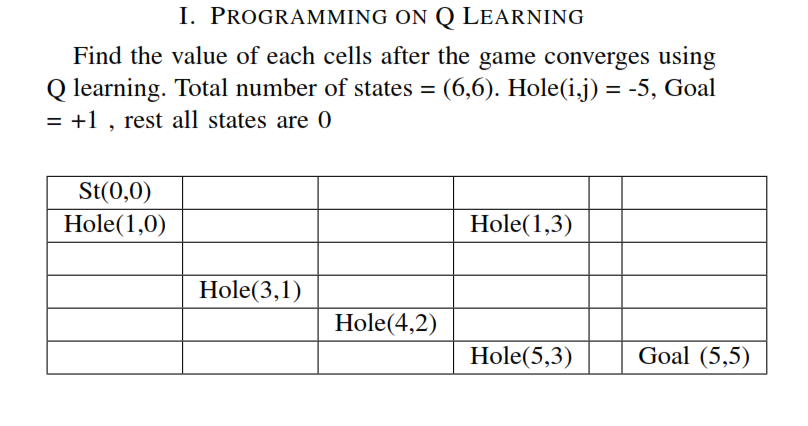Find the value of each cells after the game converges using Q learning. Total number of states = (6,6). Hole(i,j) = -5, Goal = +1 , rest all states are 0

In [16]:
import random
random.seed(42)  # make runs reproducible


# STEP 1: Define the environment

In [17]:
# We represent states as (row, col), 0-indexed. The agent starts at START.
ROWS, COLS = 6, 6
START = (0, 0)

In [18]:
# Terminal states: stepping into any HOLE or the GOAL ends the episode.
HOLES = {(1, 0), (1, 3), (3, 1), (4, 2), (5, 3)}

GOAL = (5, 5)

In [19]:
# Rewards by definition of the task:
# - moving into a hole gives -5
# - moving into the goal gives +1
# - moving into any other cell gives 0

def reward_for(state):
    if state in HOLES:
        return -5
    if state == GOAL:
        return +1
    return 0

In [20]:
# Actions: up, down, left, right, each as a delta (drow, dcol)
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # indices 0..3

NUM_ACTIONS = len(ACTIONS)

In [21]:
# A helper to clamp moves to the grid
def in_bounds(r, c):
    return 0 <= r < ROWS and 0 <= c < COLS

In [22]:
# Environment's transition function:
# Given a state and an action index, compute the next state, reward, and done flag.
def step(state, action_index):
    r, c = state
    dr, dc = ACTIONS[action_index]
    nr, nc = r + dr, c + dc

    # If action would leave the grid, we "bump" into the wall: stay in the same cell.
    if not in_bounds(nr, nc):
        nr, nc = r, c

    next_state = (nr, nc)
    rwd = reward_for(next_state)

    # Episode terminates if we stepped into a hole or the goal
    done = (next_state in HOLES) or (next_state == GOAL)
    return next_state, rwd, done

# STEP 2: Create and initialize the Q-table


Q is a 6x6x4 nested list filled with 0.0: Q[row][col][action]

We keep Q-values for every (state, action).

In [23]:
Q = [[[0.0 for _ in range(NUM_ACTIONS)] for _ in range(COLS)] for _ in range(ROWS)]

# STEP 3: Define hyperparameters and exploration logic

In [24]:
alpha = 0.1            # alpha: learning rate (how fast we incorporate new information)

gamma = 0.95          # - gamma: discount factor (how much we value future rewards)

epsilon = 1.0         # - epsilon: exploration rate for epsilon-greedy policy

min_epsilon = 0.05     # minimum exploration rate

epsilon_decay = 0.999  # shrinking epsilon a tiny bit each episode

In [25]:
# Training schedule
EPISODES = 12000       # more episodes → closer to convergence

MAX_STEPS = 200        # cap steps per episode to avoid infinite wandering

#STEP 4: Helper to pick an action (epsilon-greedy)

In [26]:
def argmax_with_random_tie_breaking(q_values):
    """
    Given a list like [q_up, q_down, q_left, q_right],
    return the index of the maximum Q, breaking ties uniformly at random.
    """
    max_q = max(q_values)
    candidates = [i for i, q in enumerate(q_values) if q == max_q]
    return random.choice(candidates)

In [27]:
def choose_action(state, eps):
    """
    With probability eps, picking a random action (exploration).
    Otherwise, picking the greedy action that maximizes Q(s, a) (exploitation).
    """
    if random.random() < eps:
        return random.randrange(NUM_ACTIONS)
    r, c = state
    return argmax_with_random_tie_breaking(Q[r][c])

# STEP 5: The Q-learning update inside the train loop

Q(s,a) ← Q(s,a) + α * ( r + γ * max_a' Q(s', a')  − Q(s,a) )

If s' is terminal, we take max_a' Q(s', a') = 0 by convention.

In [28]:
def train():
    global epsilon
    for ep in range(EPISODES):
        state = START
        for _ in range(MAX_STEPS):

            # 5.1 pick action using epsilon-greedy
            a = choose_action(state, epsilon)

            # 5.2 take action, observe next_state, reward, and whether episode ended
            next_state, rwd, done = step(state, a)

            # 5.3 compute the target: r + gamma * max_a' Q(next_state, a')  (0 if terminal)
            nr, nc = next_state
            if done:
                next_best = 0.0
            else:
                next_best = max(Q[nr][nc])

            # 5.4 TD error and Q update
            sr, sc = state
            old_q = Q[sr][sc][a]
            td_target = rwd + gamma * next_best
            td_error = td_target - old_q
            Q[sr][sc][a] = old_q + alpha * td_error

            # 5.5 transition
            state = next_state
            if done:
                break

        # 5.6 decay epsilon a tiny bit after each episode (less exploration over time)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

In [29]:
# Run training
train()

# ---------------------------------------------------------------
# STEP 6: state-value function V(s) after convergence
# ---------------------------------------------------------------
By definition, V(s) = max_a Q(s, a).

For terminal states, V(terminal) = 0.

- V_learned: the strict RL convention (terminals = 0)

- V_display: the same but showing hole cells as -5 and goal as +1

In [30]:
V_learned = [[0.0 for _ in range(COLS)] for _ in range(ROWS)]

for r in range(ROWS):
    for c in range(COLS):
        V_learned[r][c] = max(Q[r][c])


In [31]:
V_display = [[v for v in row] for row in V_learned]  # copy

for (hr, hc) in HOLES:
    V_display[hr][hc] = -5.0

V_display[GOAL[0]][GOAL[1]] = 1.0


# Pretty-print a table with 2 decimals for readability

In [32]:
def print_grid(grid, title):
    print("\n" + title)
    for r in range(ROWS):
        row = []
        for c in range(COLS):
            row.append(f"{grid[r][c]:6.2f}")
        print(" ".join(row))

In [33]:
print_grid(V_learned, "V(s) after training (terminals = 0 by convention):")
print_grid(V_display, "V(s) for display (holes = -5, goal = +1):")


V(s) after training (terminals = 0 by convention):
  0.63   0.66   0.70   0.66   0.70   0.28
  0.00   0.70   0.74   0.00   0.81   0.79
  0.66   0.74   0.77   0.81   0.86   0.90
  0.25   0.00   0.81   0.86   0.90   0.95
  0.01   0.00   0.00   0.90   0.95   1.00
  0.00   0.00   0.00   0.00   1.00   0.00

V(s) for display (holes = -5, goal = +1):
  0.63   0.66   0.70   0.66   0.70   0.28
 -5.00   0.70   0.74  -5.00   0.81   0.79
  0.66   0.74   0.77   0.81   0.86   0.90
  0.25  -5.00   0.81   0.86   0.90   0.95
  0.01   0.00  -5.00   0.90   0.95   1.00
  0.00   0.00   0.00  -5.00   1.00   1.00
